# Sentiment Analysis on Tweets with BERT

Dataset used: [tweet_eval dataset (emotion subset)](https://huggingface.co/datasets/cardiffnlp/tweet_eval)


## Imports


In [2]:
import time
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)


In [3]:

print(torch.cuda.is_available())
torch.cuda.set_device(5)  # if all GPUs are visible and 5 is free
device = torch.device("cuda")



print("CONDA_DEFAULT_ENV:", os.environ.get("CONDA_DEFAULT_ENV"))  # env name if set [web:2][web:3]
print("CONDA_PREFIX:", os.environ.get("CONDA_PREFIX"))            # full path to env, if using conda [web:2]
print("Python executable:", sys.executable)                       # path to the python binary [web:2]

print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))  # shows current value, e.g. "5" [web:7][web:10][web:16]


True
CONDA_DEFAULT_ENV: base
CONDA_PREFIX: /usr/local/anaconda3
Python executable: /home/anandvh/.conda/envs/dl_final/bin/python
CUDA_VISIBLE_DEVICES: None


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## Loading & Preprocessing Data


### Data loading


In [5]:
ds_train = load_dataset("cardiffnlp/tweet_eval", "emotion", split="train")
ds_test = load_dataset("cardiffnlp/tweet_eval", "emotion", split="test")
ds_val = load_dataset("cardiffnlp/tweet_eval", "emotion", split="validation")


In [6]:
ds_train[0]


{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': 2}

### Preprocessing


Normalizing all tweets to lowercase


In [7]:
def lower_text(example):
    example["text"] = str(example["text"]).lower()
    return example


ds_train = ds_train.map(lower_text)
ds_test = ds_test.map(lower_text)
ds_val = ds_val.map(lower_text)


In [8]:
def apply_preprocess(example):
    text = example["text"]

    new_text = []

    # change all tags to users to "@user" and all links to "http"
    for t in text.split(" "):
        t = "@user" if t.startswith("@") and len(t) > 1 else t
        t = "http" if t.startswith("http") else t
        new_text.append(t)

    cleaned_text = " ".join(new_text)
    cleaned_text = html.unescape(cleaned_text)

    example["text"] = cleaned_text

    return example


ds_train = ds_train.map(apply_preprocess)
ds_val = ds_val.map(apply_preprocess)
ds_test = ds_test.map(apply_preprocess)


### Tokenize the features

The label is already an integer, so only the text (the tweets themselves) needs to be tokenized


In [9]:
BERT_MODEL = "google-bert/bert-base-uncased"

bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=False)


def bert_tokenization(example):
    return bert_tokenizer(example["text"], padding="max_length", max_length=128, truncation=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

#### BERT MODEL


In [10]:
ds_train_tokenized_bert = ds_train.map(bert_tokenization, batched=True)
ds_test_tokenized_bert = ds_test.map(bert_tokenization, batched=True)
ds_val_tokenized_bert = ds_val.map(bert_tokenization, batched=True)


Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

Change format of BERT tokenized datasets into tensors, so that we can use PyTorch

The `input_ids`, `token_type_ids`, and `attention_mask` columns will be the actual inputs to the model


In [11]:
ds_train_tokenized_bert.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])
ds_test_tokenized_bert.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])
ds_val_tokenized_bert.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])


ds_train_tokenized_bert.format


{'type': 'torch',
 'format_kwargs': {},
 'columns': ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
 'output_all_columns': False}

In [12]:
# 1. Define a filter to find None values

def find_none(example):
    return example["text"] is None


# 2. Apply it to the training set
bad_rows = ds_train.filter(find_none)

print(f"Total rows in train: {len(ds_train)}")
print(f"Rows with None:      {len(bad_rows)}")


Total rows in train: 3257
Rows with None:      0


### Training BERT Model


In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="macro"
    )
    acc = accuracy_score(labels, predictions)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }


print("\n" + "=" * 30)
print(" TRAINING MODEL: BERT")
print("=" * 30)

model_bert = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=4)

args_bert = TrainingArguments(
    output_dir="/data/jiang/anandvh/deep-learning-final-project/results_bert",
    num_train_epochs=3,
    per_device_train_batch_size=16,  # Reduce to 8 if you get CUDA OOM error
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_first_step=True,
    save_total_limit=1,
    learning_rate=1e-4,
    load_best_model_at_end=True,
    weight_decay=0.01,
    report_to="none",  # Disable wandb logging to keep output clean
)

trainer_bert = Trainer(
    model=model_bert,
    args=args_bert,
    train_dataset=ds_train_tokenized_bert,
    eval_dataset=ds_val_tokenized_bert,
    compute_metrics=compute_metrics,
)

trainer_bert.train()



 TRAINING MODEL: BERT


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/anandvh/.conda/envs/dl_final/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.925100,0.624128,0.767380,0.641857,0.659339,0.646022
2,0.480700,0.593921,0.775401,0.707893,0.704326,0.712600
3,0.271200,0.615076,0.788770,0.728747,0.723833,0.736855


/home/anandvh/.conda/envs/dl_final/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/anandvh/.conda/envs/dl_final/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=78, training_loss=0.5646587610244751, metrics={'train_runtime': 36.5141, 'train_samples_per_second': 267.595, 'train_steps_per_second': 2.136, 'total_flos': 642726071829504.0, 'train_loss': 0.5646587610244751, 'epoch': 3.0})

In [14]:
# Evaluate on validation and test sets
eval_results = trainer_bert.evaluate()
print(eval_results)


test_results = trainer_bert.evaluate(ds_test_tokenized_bert)
print(test_results)

logs = pd.DataFrame(trainer_bert.state.log_history)


/home/anandvh/.conda/envs/dl_final/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.5939213037490845, 'eval_accuracy': 0.7754010695187166, 'eval_f1': 0.7078929438531728, 'eval_precision': 0.7043259996286256, 'eval_recall': 0.7126000883238736, 'eval_runtime': 0.2678, 'eval_samples_per_second': 1396.322, 'eval_steps_per_second': 3.733, 'epoch': 3.0}


/home/anandvh/.conda/envs/dl_final/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.5140295028686523, 'eval_accuracy': 0.812807881773399, 'eval_f1': 0.7755584675594487, 'eval_precision': 0.7743207462895407, 'eval_recall': 0.7769378260933524, 'eval_runtime': 0.8799, 'eval_samples_per_second': 1614.991, 'eval_steps_per_second': 3.41, 'epoch': 3.0}


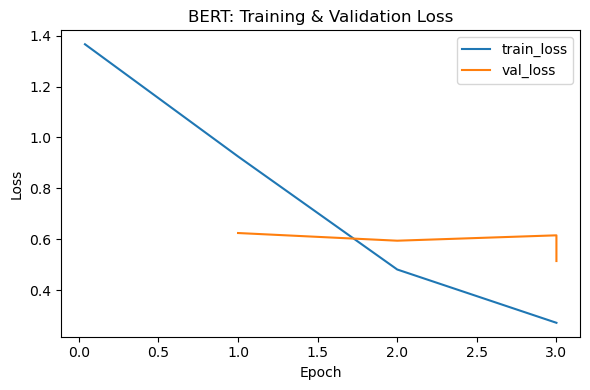

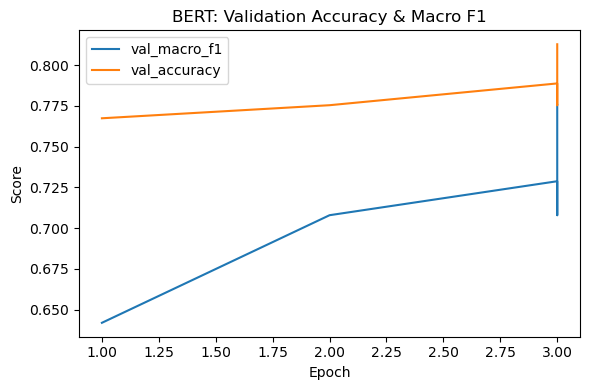

/home/anandvh/.conda/envs/dl_final/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test classification report:
              precision    recall  f1-score   support

       anger     0.8684    0.8513    0.8597       558
         joy     0.8022    0.8268    0.8143       358
    optimism     0.6210    0.6260    0.6235       123
     sadness     0.8058    0.8037    0.8047       382

    accuracy                         0.8128      1421
   macro avg     0.7743    0.7769    0.7756      1421
weighted avg     0.8135    0.8128    0.8130      1421



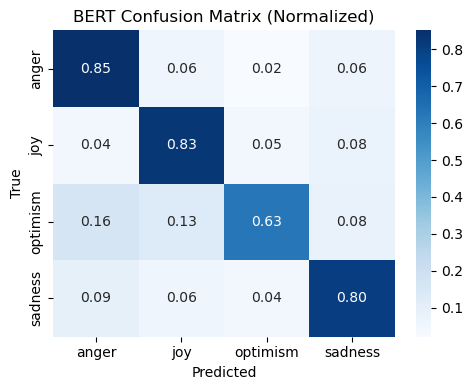

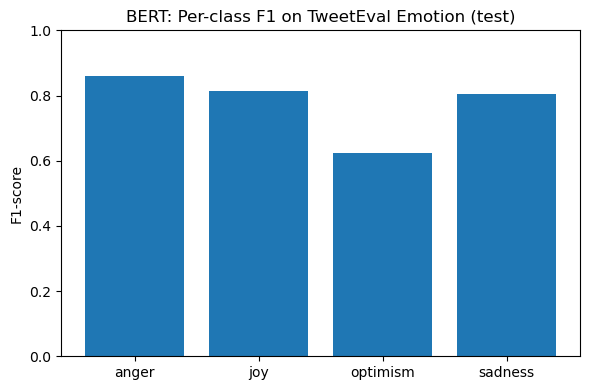

In [15]:
# --------------------
# Training curves
# --------------------
logs = pd.DataFrame(trainer_bert.state.log_history)

train_logs = logs[logs.get("loss").notnull()][["epoch", "loss"]]
eval_logs = logs[logs.get("eval_loss").notnull()][
    ["epoch", "eval_loss", "eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]
]

plt.figure(figsize=(6, 4))
plt.plot(train_logs["epoch"], train_logs["loss"], label="train_loss")
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BERT: Training & Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(eval_logs["epoch"], eval_logs["eval_f1"], label="val_macro_f1")
plt.plot(eval_logs["epoch"], eval_logs["eval_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("BERT: Validation Accuracy & Macro F1")
plt.legend()
plt.tight_layout()
plt.show()

# --------------------
# Final test evaluation
# --------------------
test_pred = trainer_bert.predict(ds_test_tokenized_bert)
y_true = test_pred.label_ids
y_pred = np.argmax(test_pred.predictions, axis=-1)

# get label names directly from the dataset
label_names = ds_train.features["label"].names

print("Test classification report:")
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

# --------------------
# Confusion matrix
# --------------------
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BERT Confusion Matrix (Normalized)")
plt.tight_layout()
plt.show()

# --------------------
# Per-class F1 bar plot
# --------------------
report = classification_report(
    y_true, y_pred, target_names=label_names, output_dict=True, zero_division=0
)

per_class_f1 = [report[label]["f1-score"] for label in label_names]

plt.figure(figsize=(6, 4))
plt.bar(label_names, per_class_f1)
plt.ylim(0, 1.0)
plt.ylabel("F1-score")
plt.title("BERT: Per-class F1 on TweetEval Emotion (test)")
plt.tight_layout()
plt.show()
